In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 18 - Heuristic decision-making

## 18.1 Take-the-best
The take-the-best (TTB) model of decision-making (Gigerenzer & Goldstein, 1996) is a simple but influential account of how people choose between two stimuli on some criterion, and a good example of the general class of heuristic decision-making models (e.g., Gigerenzer & Todd, 1999; Gigerenzer & Gaissmaier, 2011; Payne, Bettman, & Johnson, 1990).


$$ t_q = \text{TTB}_{s}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_q = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_q = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/StopSearchData.mat')

y = np.squeeze(matdata['y'])
m = np.squeeze(np.float32(matdata['m']))
p = np.squeeze(matdata['p'])
v = np.squeeze(np.float32(matdata['v']))
x = np.squeeze(np.float32(matdata['x']))

# Constants
n,nc=np.shape(m) # number of stimuli and cues
nq,junk1=np.shape(p) # number of questions
ns,junk=np.shape(y) # number of subjects

In [3]:
s = np.argsort(v)
t=[]
# TTB Model For Each Question
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    tmp1=np.zeros(nc)
    for j in range(nc):
        tmp1[j] = (m[p[q,0]-1,j]-m[p[q,1]-1,j])*(2**(s[j]))
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 = np.sum(tmp1)
    tmp3 = -1*np.float32(-tmp2>0)+np.float32(tmp2>0)
    t.append(tmp3+1)
tmat=np.int8(np.repeat(t,ns).reshape(ns,-1))

Applied interval-transform to gamma and added transformed gamma_interval to model.
Assigned NUTS to gamma_interval
 [-----------------100%-----------------] 3000 of 3000 complete in 1.0 sec

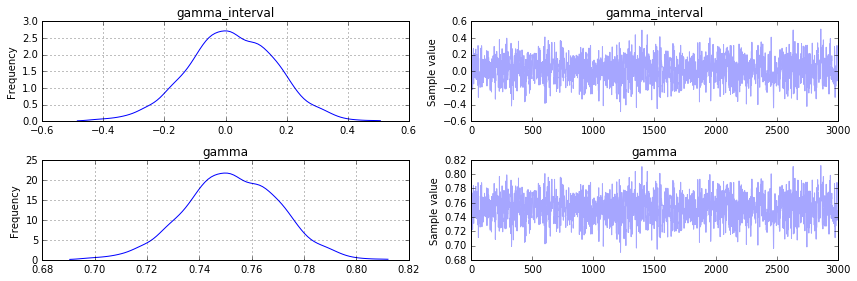

In [4]:
with pm.Model() as model1:
    gamma = pm.Uniform("gamma",lower=.5,upper=1)
    gammat = T.stack([1-gamma,.5,gamma])
    yiq = pm.Bernoulli("yiq",p=gammat[tmat.flatten()],observed=y.flatten())
    trace1 = pm.sample(3e3)
pm.traceplot(trace1)
plt.show()

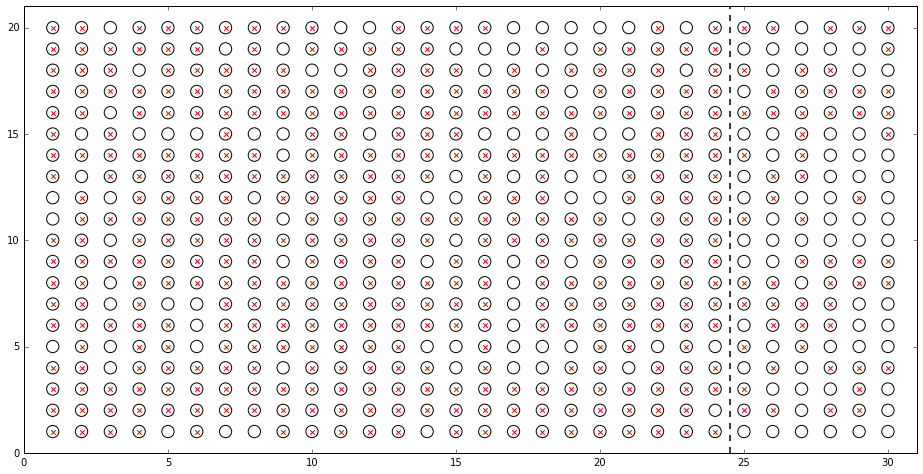

In [5]:
ppc = pm.sample_ppc(trace1, samples=100, model=model1, size=100)
yiqpred=np.asarray(ppc['yiq']).reshape(10000,ns*nq)
fig = plt.figure(figsize=(16, 8))
x1=np.repeat(np.arange(ns)+1,nq).reshape(ns,-1).flatten()
y1=np.repeat(np.arange(nq)+1,ns).reshape(nq,-1).T.flatten()

plt.scatter(y1,x1,s=np.mean(yiqpred,axis=0)*200,c='w')
plt.scatter(y1[y.flatten()==1],x1[y.flatten()==1],marker="x",c='r')
plt.plot(np.ones(100)*24.5,np.linspace(0,21,100),'--',lw=1.5,c='k')
plt.axis([0,31,0,21])
plt.show()

## 18.2 Stopping
A common comparison (e.g., Bergert & Nosofsky, 2007; Lee & Cummins, 2004) is between TTB and a model often called the Weighted ADDitive (WADD) model, which sums the evidence for both decision alternatives over all available cues, and chooses the one with the greatest evidence.

$$ \phi \sim \text{Uniform}(0,1)$$
$$ z_i \sim \text{Bernoulli}(\phi)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 0$} \\
\end{cases}  $$  

$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [6]:
s = np.argsort(v)
t=[]
# TTB Model For Each Question
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    tmp1=np.zeros(nc)
    for j in range(nc):
        tmp1[j] = (m[p[q,0]-1,j]-m[p[q,1]-1,j])*(2**(s[j]))
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 = np.sum(tmp1)
    tmp3 = -1*np.float32(-tmp2>0)+np.float32(tmp2>0)
    t.append(tmp3+1)
tmat=np.int8(np.repeat(t,ns).reshape(ns,-1))

w=[]
# WADD Model For Each Question
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    tmp1=np.zeros(nc)
    for j in range(nc):
        tmp1[j] = (m[p[q,0]-1,j]-m[p[q,1]-1,j])*x[j]
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 = np.sum(tmp1)
    tmp3 = -1*np.float32(-tmp2>0)+np.float32(tmp2>0)
    w.append(tmp3+1)
wmat=np.int8(np.repeat(w,ns).reshape(ns,-1))

print(t)
print(w)

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Applied interval-transform to phi and added transformed phi_interval to model.
Applied interval-transform to gamma and added transformed gamma_interval to model.
Assigned NUTS to phi_interval
Assigned BinaryGibbsMetropolis to zi
Assigned NUTS to gamma_interval
 [-----------------100%-----------------] 3000 of 3000 complete in 11.9 sec

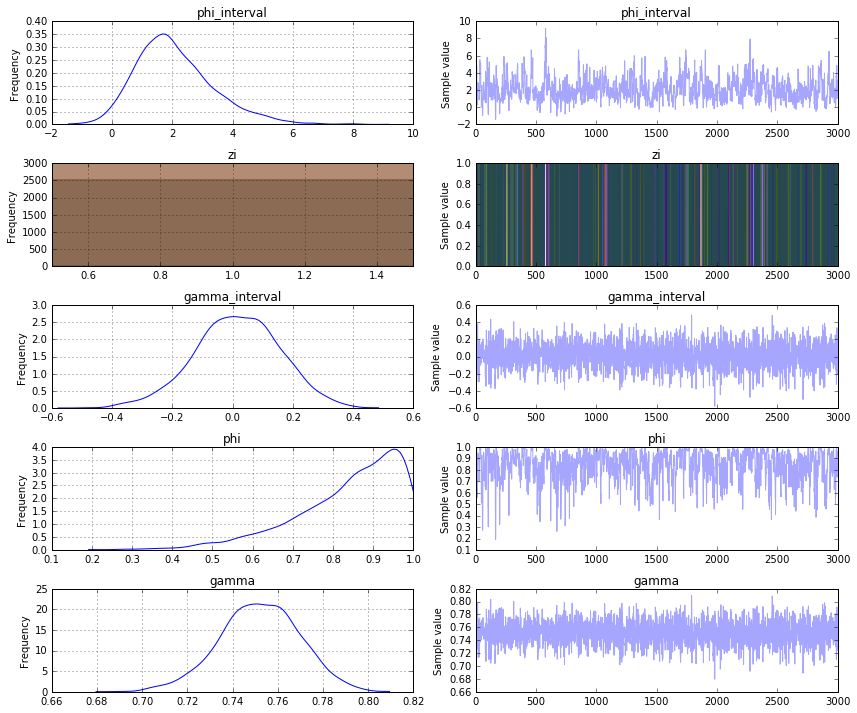

In [7]:
with pm.Model() as model2:
    phi = pm.Uniform("phi",lower=0,upper=1,testval=.5)
    # zi = pm.Bernoulli("zi",p=phi,shape=(ns,1))
    zi = pm.Bernoulli("zi",p=phi,shape=ns)
    gamma = pm.Uniform("gamma",lower=.5,upper=1)
    gammat = T.stack([1-gamma,.5,gamma])

#     ziall = T.repeat(zi,nq,axis=1)
#     t2 = T.switch(T.eq(ziall,1),tmat,wmat)
#     yiq = pm.Bernoulli("yiq",p=gammat[t2.flatten()],observed=y.flatten())
    
    yiq=[]
    for i in range(ns):
        # t2=tmat[i]*(1-zi[i])+wmat[i]*zi[i]
        t2 = T.switch(T.eq(zi[i],1),tmat[i],wmat[i])
        yiq.append([pm.Bernoulli("yiq_%i"%i,p=gammat[t2],observed=y[i])])
    
    start=pm.find_MAP()
    trace2 = pm.sample(3e3,start=start)
    
pm.traceplot(trace2)
plt.show()

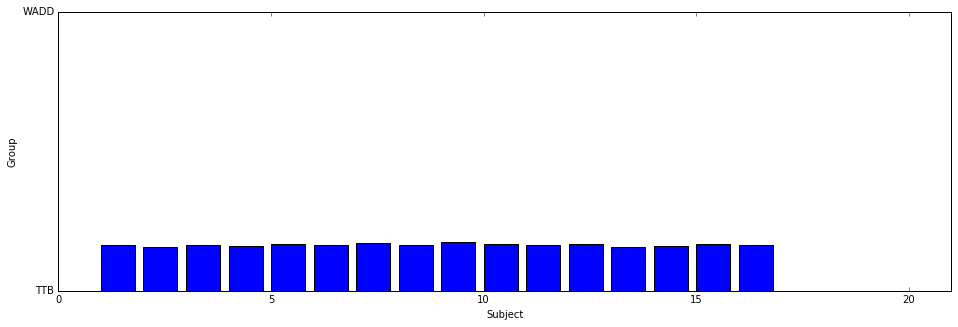

In [8]:
fig = plt.figure(figsize=(16, 5))
zitrc=trace2['zi'][500:]
plt.bar(np.arange(ns)+1,1-np.mean(zitrc,axis=0))
plt.yticks([0,1],('TTB','WADD'))
plt.xlabel('Subject')
plt.ylabel('Group')
plt.axis([0,21,0,1])
plt.show()

## 18.3 Searching


$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ t_{iq} = \text{TTB}_{si}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

Applied interval-transform to gamma and added transformed gamma_interval to model.
Applied log-transform to v1 and added transformed v1_log to model.
 [-----------------100%-----------------] 3000 of 3000 complete in 36.2 sec

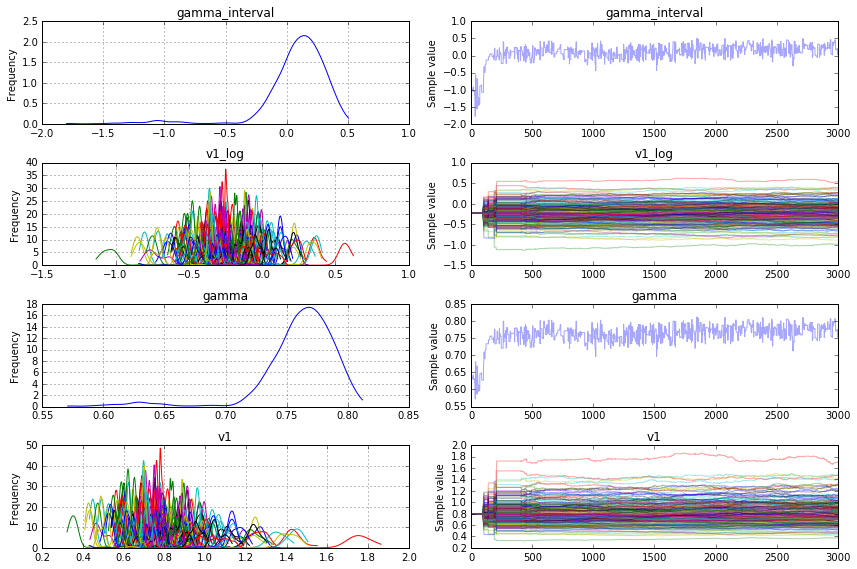

In [9]:
import theano
with pm.Model() as model3:
    gamma = pm.Uniform("gamma",lower=.5,upper=1)
    gammat = T.stack([1-gamma,.5,gamma])
    
    yiq=[]
    v1=pm.HalfNormal("v1",sd=1,shape=(ns,nc))
    for i in range(ns):
        s1 = v1[i].argsort()
        t=[]
        # TTB Model For Each Question
        for q in range(nq):
            # Add Cue Contributions To Mimic TTB Decision
            tmp1=theano.shared(np.zeros(nc))
            for j in range(nc):
                tmpval=(m[p[q,0]-1,j]-m[p[q,1]-1,j])*T.pow(2,s1[j])
                tmp1 = T.set_subtensor(tmp1[j],tmpval)
            # Find if Cue Favors First, Second, or Neither Stimulus
            tmp2 = T.sum(tmp1)
            tmp3 = -1*(-tmp2>0)+(tmp2>0)
            t.append(tmp3+1)
        
        yiq.append([pm.Bernoulli("yiq_%i"%i,p=gammat[t],observed=y[i])])
    
    trace3 = pm.sample(3e3,step=pm.Metropolis())
pm.traceplot(trace3)
plt.show()

In [10]:
v1trace=trace3[v1][500:]
v1m=np.mean(v1trace,axis=0)
print(np.argsort(v))
for i in range(ns):
    print(v1m[i].argsort(),i+1)

[8 7 6 5 4 3 2 1 0]
[6 4 7 8 3 0 1 2 5] 1
[2 5 6 7 4 3 8 0 1] 2
[8 7 2 4 3 1 0 6 5] 3
[0 3 7 2 4 8 6 5 1] 4
[8 3 0 7 2 5 4 6 1] 5
[4 6 3 7 8 0 1 2 5] 6
[8 0 3 4 5 7 6 2 1] 7
[2 5 6 1 3 7 4 8 0] 8
[6 1 5 3 4 8 7 0 2] 9
[5 4 2 3 0 7 8 1 6] 10
[5 4 6 1 3 2 8 0 7] 11
[2 8 3 5 0 7 1 4 6] 12
[5 0 3 4 1 6 8 7 2] 13
[8 6 2 4 3 5 7 1 0] 14
[2 3 0 6 8 4 5 1 7] 15
[8 1 5 0 2 7 3 4 6] 16
[2 6 8 5 7 3 1 0 4] 17
[0 5 6 3 7 4 8 1 2] 18
[3 2 4 6 8 7 0 1 5] 19
[2 0 8 1 3 6 7 5 4] 20


## 18.4 Searching and stopping


$$ \phi_{i} \sim \text{Uniform}(0,1)$$
$$ z_{iq} \sim \text{Bernoulli}(\phi_{i})$$
$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}_{si}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 0$} \\
\end{cases}  $$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

Applied interval-transform to gamma and added transformed gamma_interval to model.
Applied interval-transform to phi and added transformed phi_interval to model.
Applied log-transform to v1 and added transformed v1_log to model.
Assigned NUTS to gamma_interval
Assigned NUTS to phi_interval
Assigned BinaryGibbsMetropolis to zi
Assigned NUTS to v1_log
 [-----------------100%-----------------] 3001 of 3000 complete in 21535.3 sec

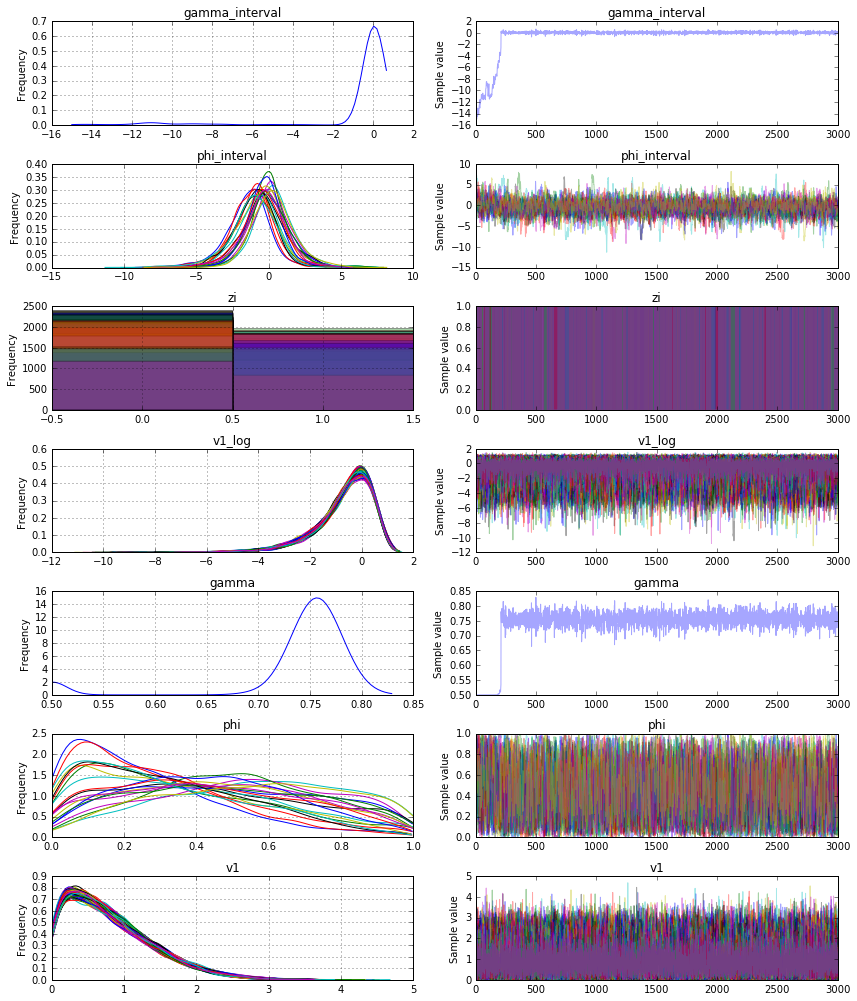

In [11]:
w1=[]
# WADD Model For Each Question
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    tmp1=np.zeros(nc)
    for j in range(nc):
        tmp1[j] = (m[p[q,0]-1,j]-m[p[q,1]-1,j])*x[j]
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 = np.sum(tmp1)
    tmp3 = -1*np.float32(-tmp2>0)+np.float32(tmp2>0)
    w1.append(tmp3+1)
w=np.int8(w1)

with pm.Model() as model4:
    gamma = pm.Uniform("gamma",lower=.5,upper=1)
    gammat = T.stack([1-gamma,.5,gamma])
    
    phi = pm.Uniform("phi",lower=0,upper=1,shape=(ns,1))
    phiall = T.repeat(phi,nq,axis=1)
    zi = pm.Bernoulli("zi",p=phiall,shape=(ns,nq))
    
    yiq=[]
    v1=pm.HalfNormal("v1",sd=1,shape=(ns,nc))
    for i in range(ns):
        s1 = v1[i].argsort()
        t=[]
        # TTB Model For Each Question
        for q in range(nq):
            # Add Cue Contributions To Mimic TTB Decision
            tmp1=theano.shared(np.zeros(nc))
            for j in range(nc):
                tmpval=(m[p[q,0]-1,j]-m[p[q,1]-1,j])*T.pow(2,s1[j])
                tmp1 = T.set_subtensor(tmp1[j],tmpval)
            # Find if Cue Favors First, Second, or Neither Stimulus
            tmp2 = T.sum(tmp1)
            tmp3 = -1*(-tmp2>0)+(tmp2>0)
            t.append(tmp3+1)
            
        t2 = T.switch(T.eq(zi[i],1),t,w)
        yiq.append([pm.Bernoulli("yiq_%i"%i,p=gammat[t2],observed=y[i])])
    
    start=pm.find_MAP()
    trace4 = pm.sample(3e3,start=start)
    
pm.traceplot(trace4)
plt.show()